In [1]:
import os
import gc
import cv2
import time
import itertools

import numpy as np
import pandas as pd
import tensorflow as tf

from keras import backend as K
from matplotlib import pyplot as plt

from glob import glob
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras import models
from keras_preprocessing.image import ImageDataGenerator

from keras.layers import Input
from keras.models import Sequential, Model
from keras.layers.core import Dense
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense
from keras.models import Sequential, Model
from keras.layers import BatchNormalization, Activation
from keras import regularizers, applications, optimizers, initializers
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.applications import EfficientNetB6
from tensorflow.keras.applications import EfficientNetB7

In [2]:
def calculate_cm(y_true, y_pred):
    fp = np.sum((y_pred == 1) & (y_true == 0))
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    tn = np.sum((y_pred == 0) & (y_true == 0))
    return tp, fp, fn, tn

def calculate_recall(tp, fp, fn, tn):
    return (tp)/(tp + fn)

def calculate_fallout(tp, fp, fn, tn):
    return (fp)/(fp + tn)

def calculate_fpr_tpr(y_true, y_pred):
    tp, fp, fn, tn = calculate_cm(y_true, y_pred)
    tpr = calculate_recall(tp, fp, fn, tn)
    fpr = calculate_fallout(tp, fp, fn, tn)
    return fpr, tpr

In [3]:
image_paths = {os.path.basename(x): x for x in glob(os.path.join('.', 'images', '*.png'))}
df = pd.read_csv("./dataset_information/Data_Entry_2017.csv")

df = df.drop(
    columns = [
        "Follow-up #", 
        "Patient ID", 
        "Patient Age", 
        "Patient Gender", 
        "OriginalImage[Width",
        "Height]",
        "OriginalImagePixelSpacing[x",
        "y]",
#         "Unnamed: 11",
        "View Position"
    ], 
    axis = 1
)

df["Image Paths"] = " "
for row_index in tqdm(range(len(df)), ncols = 100):
    img_name = df.iloc[row_index][0]
    path = image_paths[img_name]
    df["Image Paths"][row_index] = path

unique_labels = set(itertools.chain.from_iterable(df["Finding Labels"].apply(lambda x : x.split('|')).values)) 
one_hot_labels = pd.DataFrame(0.0, index = np.arange(len(df)), columns = unique_labels)

for index, row in df.iterrows():
    labels = row["Finding Labels"].split('|')
    for label in labels:
        one_hot_labels.iloc[index][label] = 1.0

df = pd.concat([df, one_hot_labels], axis = 1)
df = df.drop(columns = ["Finding Labels"], axis = 1)
df.head()

100%|█████████████████████████████████████████████████████| 112120/112120 [01:12<00:00, 1545.63it/s]


,Image Index,Image Paths,Hernia,Fibrosis,Atelectasis,Nodule,Cardiomegaly,Pleural_Thickening,Mass,Edema,Consolidation,Emphysema,No Finding,Pneumothorax,Effusion,Infiltration,Pneumonia
0,00000001_000.png,.\images\00000001_000.png,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,.\images\00000001_001.png,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,.\images\00000001_002.png,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,00000002_000.png,.\images\00000002_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,.\images\00000003_000.png,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# df_train, df_test = train_test_split(dataset_info.sample(n = 60000), test_size = 0.20, random_state = 142)
df_train, df_test = train_test_split(df, test_size = 0.20, random_state = 0)
df_train, df_val = train_test_split(df_train, test_size = 0.10, random_state = 0)

print(f"Training Samples: {len(df_train)}\nValidation Samples: {len(df_val)}\nTesting Samples: {len(df_test)}")

Training Samples: 80726
Validation Samples: 8970
Testing Samples: 22424


In [13]:
CLASS_LABELS = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", 
    "Infiltration", "Mass", "No Finding", "Nodule", "Pleural_Thickening", "Pneumonia","Pneumothorax"
]
IMAGE_SIZE = (224, 224,)
BATCH_SIZE = 24
EPOCHS = 15

BETA_FOR_BIASED_RECALL = 1.3
BETA_FOR_BIASED_PRECISION = 0.7
BETA_WITH_NO_BIAS = 1

THRESHOLDS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

METRICS = [
  tf.keras.metrics.TruePositives(name = 'tp'),
  tf.keras.metrics.FalsePositives(name = 'fp'),
  tf.keras.metrics.TrueNegatives(name = 'tn'),
  tf.keras.metrics.FalseNegatives(name = 'fn'), 
  tf.keras.metrics.BinaryAccuracy(name = 'binary_accuracy'),
  tf.keras.metrics.Precision(name = 'precision', thresholds = 0.3),
  tf.keras.metrics.Recall(name = 'recall', thresholds = 0.3),
  tf.keras.metrics.AUC(name = 'auc', multi_label = True, num_labels = 15, thresholds = THRESHOLDS),
  tf.keras.metrics.AUC(name = 'prc', curve = 'PR')
]

In [14]:
def flow_from_dataframe(image_generator, dataframe):
    df_gen = image_generator.flow_from_dataframe(
        dataframe,
        x_col = "Image Paths", 
        y_col = dataframe.columns[2:],
        target_size = IMAGE_SIZE,
        color_mode = 'rgb',
        class_mode = 'raw',
        shuffle = False,
        batch_size = BATCH_SIZE
    )
    return df_gen

def sharpen_image(image):
    sharp_kernel = np.array(
        [
            [0, -1, 0], 
            [-1, 5, -1], 
            [0, -1, 0]
        ])
    output = cv2.filter2D(src = image, ddepth = -1, kernel = sharp_kernel)
    return output

In [15]:
train_data_generator = ImageDataGenerator(
    rescale = 1. / 255,
    preprocessing_function = sharpen_image,
    zca_whitening = False,
    rotation_range = 20,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image 
    width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True
)
val_data_generator = ImageDataGenerator(
    rescale = 1. / 255,
    preprocessing_function = sharpen_image
)
test_data_generator = ImageDataGenerator(
    rescale = 1. / 255,
    preprocessing_function = sharpen_image
)

In [16]:
train_gen = flow_from_dataframe(image_generator = train_data_generator, dataframe = df_train)
valid_gen = flow_from_dataframe(image_generator = val_data_generator, dataframe = df_val)
test_gen = flow_from_dataframe(image_generator = test_data_generator, dataframe = df_test)

Found 80726 validated image filenames.
Found 8970 validated image filenames.
Found 22424 validated image filenames.


In [17]:
SGD_optimizer = tf.keras.optimizers.SGD(
    learning_rate = 0.0001, 
    decay = 1e-6, 
    momentum = 0.9, 
    nesterov = True
)
adam_optimizer = tf.keras.optimizers.Adam(
    learning_rate = 0.0001,
    beta_1 = 0.9,
    beta_2 = 0.999,
)

In [18]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0,
    patience = 4,
    verbose = 1,
    mode = 'auto',
    baseline = None,
    restore_best_weights = True
)

In [19]:
channels = (3,)
input_shape = IMAGE_SIZE + channels
img_input = Input(shape = input_shape)

MODEL_NAME = "VGG16"
base_model = VGG16(
    input_shape = input_shape,
    include_top = False,
    weights = "imagenet"
)

custom_classifier = Sequential()
custom_classifier.add(GlobalAveragePooling2D(input_shape = base_model.output_shape[1:]))
custom_classifier.add(Dropout(0.2))

custom_classifier.add(Dense(256))
custom_classifier.add(BatchNormalization())
custom_classifier.add(Activation('relu'))
custom_classifier.add(Dropout(0.2))

custom_classifier.add(Dense(50))
custom_classifier.add(BatchNormalization())
custom_classifier.add(Activation('relu'))
custom_classifier.add(Dropout(0.2))

custom_classifier.add(Dense(15, activation = "sigmoid"))

model = Model(inputs = base_model.input, outputs = custom_classifier(base_model.output))
# model.load_weights("/saved_weights/{MODEL_NAME}_{EPOCHS}_weights.h5")

model.compile(
    optimizer = adam_optimizer,
    loss = "binary_crossentropy",
    metrics = METRICS
)

In [20]:
start_time = time.time()

history = model.fit_generator(
    epochs = EPOCHS,
    generator = train_gen,
    steps_per_epoch = train_gen.n / train_gen.batch_size,
    validation_data = valid_gen,
    validation_steps = valid_gen.n / valid_gen.batch_size,
    shuffle = False,
    verbose = 1,
    callbacks = None
)

print(f"\nTime Taken: {(time.time() - start_time) / 3600 : .4f} Hours")

Epoch 1/15
3363/3363 [==============================] - 3761s 1s/step - loss: 0.3210 - tp: 33956.0000 - fp: 76844.0000 - tn: 1032331.0000 - fn: 67759.0000 - binary_accuracy: 0.8806 - precision: 0.1972 - recall: 0.5347 - auc: 0.5186 - prc: 0.2339 - val_loss: 0.2539 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 123173.0000 - val_fn: 11377.0000 - val_binary_accuracy: 0.9154 - val_precision: 0.2995 - val_recall: 0.5043 - val_auc: 0.4652 - val_prc: 0.2304
Epoch 2/15
3363/3363 [==============================] - 3670s 1s/step - loss: 0.2118 - tp: 29623.0000 - fp: 14403.0000 - tn: 1094772.0000 - fn: 72092.0000 - binary_accuracy: 0.9286 - precision: 0.5090 - recall: 0.4437 - auc: 0.5499 - prc: 0.4607 - val_loss: 0.2104 - val_tp: 1937.0000 - val_fp: 527.0000 - val_tn: 122646.0000 - val_fn: 9440.0000 - val_binary_accuracy: 0.9259 - val_precision: 0.4779 - val_recall: 0.4910 - val_auc: 0.5458 - val_prc: 0.4859
Epoch 3/15
3363/3363 [==============================] - 3512s 1s/step - loss: 0.20

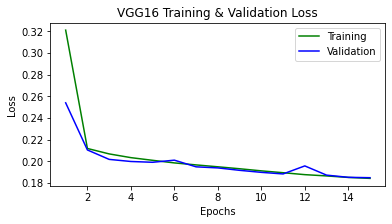

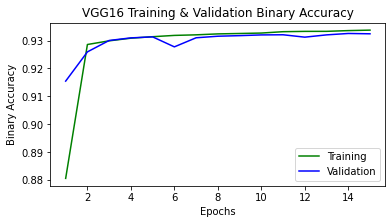

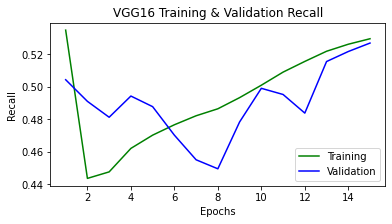

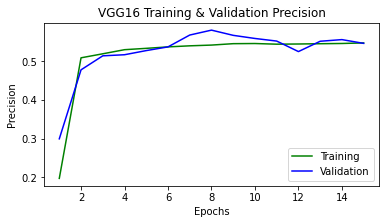

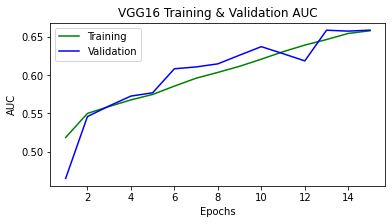

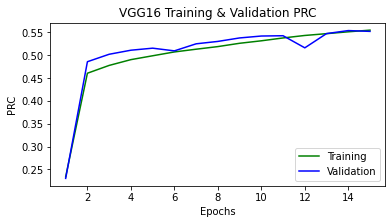

In [21]:
plt.figure(1, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['loss'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_loss'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(2, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['binary_accuracy'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_binary_accuracy'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation Binary Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Binary Accuracy')
plt.legend()
plt.show()

plt.figure(3, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['recall'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_recall'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

plt.figure(4, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['precision'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_precision'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

plt.figure(6, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['auc'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_auc'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

plt.figure(7, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['prc'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_prc'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation PRC')
plt.xlabel('Epochs')
plt.ylabel('PRC')
plt.legend()
plt.show()

In [23]:
model.save_weights(f"./saved_weights/{MODEL_NAME}_{EPOCHS}_weights.h5")
evaluation = model.evaluate(test_gen)

935/935 [==============================] - 388s 414ms/step - loss: 0.1834 - tp: 9992.0000 - fp: 4217.0000 - tn: 303835.0000 - fn: 18316.0000 - binary_accuracy: 0.9330 - precision: 0.5457 - recall: 0.5319 - auc: 0.6602 - prc: 0.5567


In [24]:
test_loss = evaluation[0]
TP = evaluation[1]
FP = evaluation[2]
TN = evaluation[3]
FN = evaluation[4]
binary_accuracy = evaluation[5] * 100
auc = evaluation[8] * 100
auc_pr = evaluation[9] * 100

specificity = (TN / (TN + FP)) * 100
recall = (TP / (TP + FN)) * 100
precision = (TP / (TP + FP)) * 100
f1_score = (2 * recall * precision) / (recall + precision)

print(f"Testing Loss: \t\t{test_loss}\n")
print(f"True Positives: \t{TP}\nFalse Positives: \t{FP}\nTrue Negatives: \t{TN}\nFalse Negatives: \t{FN}\n")
print(f"Binary Accuracy: \t{binary_accuracy}")
print(f"Average Recall: \t{recall}\nAverage Precision: \t{precision}\nF1-Score: \t\t{f1_score}\nAverage Specificity: \t{specificity}\n")
print(f"AUC: \t\t\t{auc}\nAUC-PR: \t\t{auc_pr}")

Testing Loss: 		0.18339577317237854

True Positives: 	9992.0
False Positives: 	4217.0
True Negatives: 	303835.0
False Negatives: 	18316.0

Binary Accuracy: 	93.30087900161743
Average Recall: 	35.297442419104144
Average Precision: 	70.3216271377296
F1-Score: 		47.002375520380085
Average Specificity: 	98.63107527300585

AUC: 			66.02497100830078
AUC-PR: 		55.66837787628174


In [25]:
test_gen.reset()
predictions = model.predict(test_gen)

In [26]:
def binary_accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))

def precision_threshold(threshold = 0.5):
    def precision(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(y_pred)
        precision_ratio = true_positives / (predicted_positives + K.epsilon())
        return precision_ratio
    return precision

def recall_threshold(threshold = 0.5):
    def recall(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.clip(y_true, 0, 1))
        recall_ratio = true_positives / (possible_positives + K.epsilon())
        return recall_ratio
    return recall

def fbeta_score_threshold(beta = 1, threshold = 0.5):
    def fbeta_score(y_true, y_pred):
        threshold_value = threshold
        beta_value = beta
        p = precision_threshold(threshold_value)(y_true, y_pred)
        r = recall_threshold(threshold_value)(y_true, y_pred)
        bb = beta_value ** 2
        fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
        return fbeta_score
    return fbeta_score
    
def print_results(beta, threshold, test_labels, prediction):
    accuracy = K.eval(binary_accuracy(K.variable(value = test_labels), K.variable(value = prediction)))
    precision = K.eval(precision_threshold(threshold = threshold)(K.variable(value = test_labels), K.variable(value = prediction)))
    recall = K.eval(recall_threshold(threshold = threshold)(K.variable(value = test_labels), K.variable(value = prediction)))
    f1_score = K.eval(fbeta_score_threshold(beta = beta, threshold = threshold)(K.variable(value = test_labels), K.variable(value = prediction)))
    print(f"BETA: {beta}, THRESHOLD: {threshold}")
    print (f"Binary Accuracy: \t{accuracy * 100} % \nRecall: \t\t{recall * 100} % \nPrecision: \t\t{precision * 100} % \nF1-Score: \t\t{f1_score * 100} %\n")

In [27]:
test_labels = []
for label in test_gen.labels:
    test_labels.append(label)

# # Results with F Score giving more weightage to Recall
# for threshold in THRESHOLDS:
#     print_results(beta = BETA_FOR_BIASED_RECALL, threshold = threshold, test_labels = test_labels, prediction = predictions)

# # Results with F Score giving more weightage to Precision
# for threshold in THRESHOLDS:
#     print_results(beta = BETA_FOR_BIASED_PRECISION, threshold = threshold, test_labels = test_labels, prediction = predictions)

# Results with F Score giving equal weightage to Recall and Precision
for threshold in THRESHOLDS:
    print_results(beta = BETA_WITH_NO_BIAS, threshold = threshold, test_labels = test_labels, prediction = predictions)

BETA: 1, THRESHOLD: 0.1
Binary Accuracy: 	93.30092668533325 % 
Recall: 		80.08689880371094 % 
Precision: 		31.06510043144226 % 
F1-Score: 		44.76585388183594 %

BETA: 1, THRESHOLD: 0.2
Binary Accuracy: 	93.30092668533325 % 
Recall: 		64.57538604736328 % 
Precision: 		44.28509175777435 % 
F1-Score: 		52.539294958114624 %

BETA: 1, THRESHOLD: 0.3
Binary Accuracy: 	93.30092668533325 % 
Recall: 		53.19344401359558 % 
Precision: 		54.56785559654236 % 
F1-Score: 		53.87187600135803 %

BETA: 1, THRESHOLD: 0.4
Binary Accuracy: 	93.30092668533325 % 
Recall: 		43.563657999038696 % 
Precision: 		63.14711570739746 % 
F1-Score: 		51.558417081832886 %

BETA: 1, THRESHOLD: 0.5
Binary Accuracy: 	93.30092668533325 % 
Recall: 		35.297441482543945 % 
Precision: 		70.32162547111511 % 
F1-Score: 		47.00236618518829 %

BETA: 1, THRESHOLD: 0.6
Binary Accuracy: 	93.30092668533325 % 
Recall: 		28.151053190231323 % 
Precision: 		76.36799216270447 % 
F1-Score: 		41.1377489566803 %

BETA: 1, THRESHOLD: 0.7
Binary